In [ ]:
!pip install gym[atari]
!wget http://www.atarimania.com/roms/Atari-2600-VCS-ROM-Collection.zip
!unzip -q Atari-2600-VCS-ROM-Collection.zip
!python -m atari_py.import_roms .

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from gym.utils import play
from rl.core import Processor
from rl.memory import SequentialMemory
from collections import deque

%matplotlib inline

pygame 2.1.0 (SDL 2.0.16, Python 3.7.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
env = gym.make("Breakout-v0")

In [3]:
# In case you want to play
# play.play(env)

In [4]:
# To make the ball show exactly the same as the tutorial
WINDOW_LENGTH = 3

In [5]:
np.random.seed(42)
env.reset()

# [[0, 1, 2], [1, 2, 3], [2, 3, 4]]
sequential_frame_buffer = []
temp_sequential_frames = deque(maxlen=WINDOW_LENGTH)

for i in range(10):
    
    if i == 1:
        action = 1 # INITIATE BALL
    else:
        action = 3 # LEFT
    
    obs, reward, done, info = env.step(action)
    
    if len(temp_sequential_frames) == WINDOW_LENGTH:
        sequential_frame_buffer.append(list(temp_sequential_frames))
    temp_sequential_frames.append(obs)

In [6]:
len(sequential_frame_buffer)

7

In [7]:
for i in range(len(sequential_frame_buffer)):
    print(len(sequential_frame_buffer[i]))

3
3
3
3
3
3
3


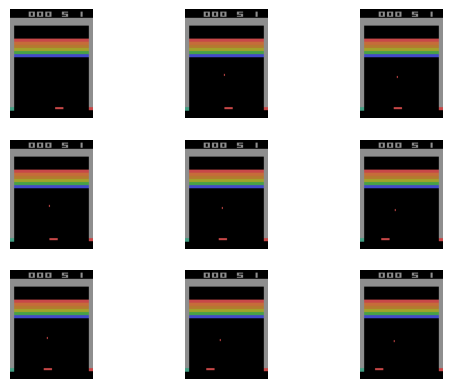

In [8]:
fig, ax = plt.subplots(3, 3)

for i in range(3):
    for j in range(3):
        ax[i][j].imshow(sequential_frame_buffer[i][j])
        ax[i][j].axis("off")
plt.show()

## Example of the made by the author of the course

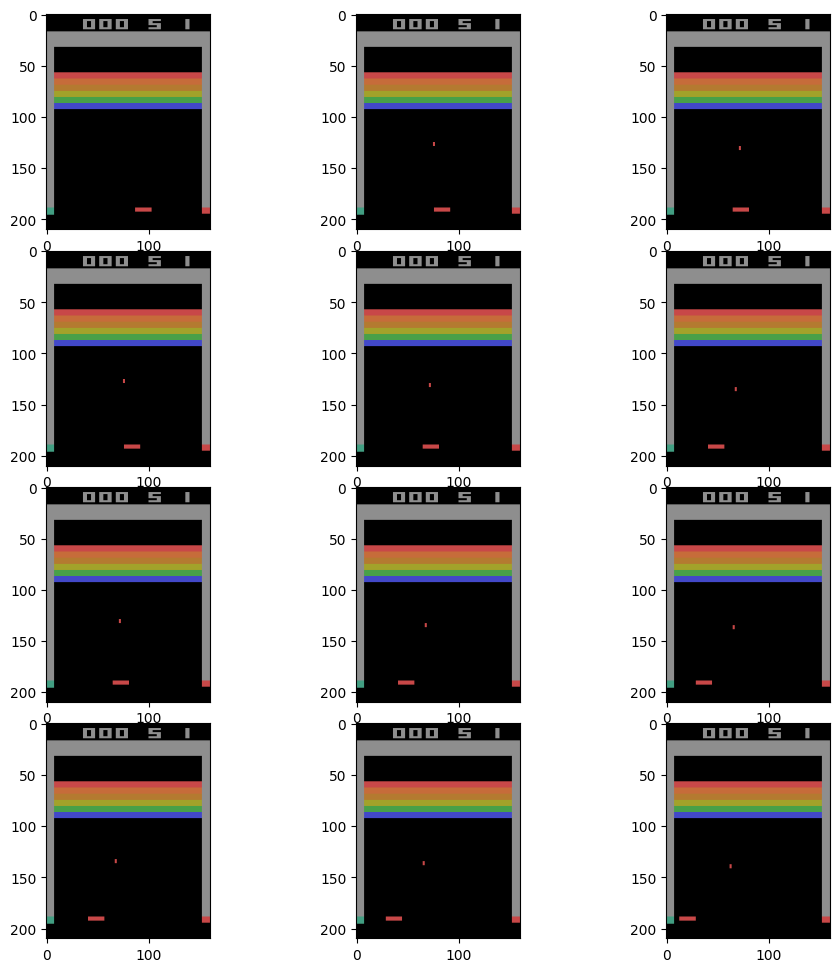

In [9]:
fig, axis = plt.subplots(4, WINDOW_LENGTH, figsize=(12, 12))
for global_index, timestep in enumerate(sequential_frame_buffer[:4]):
    for frame_index, frame in enumerate(timestep):
        axis[global_index][frame_index].imshow(frame)
        
fig.subplots_adjust(wspace=0, hspace=0.1)
plt.show()

In [10]:
memory = SequentialMemory(limit=1000, window_length=WINDOW_LENGTH)

In [11]:
sequential_frame_buffer[0][0].shape

(210, 160, 3)

## To reduce the processing time, we reduce the shape, in this case, 84x84 won't be hard to the model learn to play the game, it can recognize the game in this shape, but, if reduce to much, it would be hard for the model to learn

In [12]:
IMG_SHAPE = (84, 84)

In [13]:
class BreakOutProcessor(Processor):
    
    def process_observation(self, obs):
        # array -> Image with PIL
        img = Image.fromarray(obs)
        img = img.resize(IMG_SHAPE)
        img = img.convert("L")
        return np.array(img)

In [14]:
sample_images = []
breakout_processor = BreakOutProcessor()

env.reset()
for _ in range(200):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    proc_obs = breakout_processor.process_observation(obs)
    sample_images.append(proc_obs)

(84, 84)


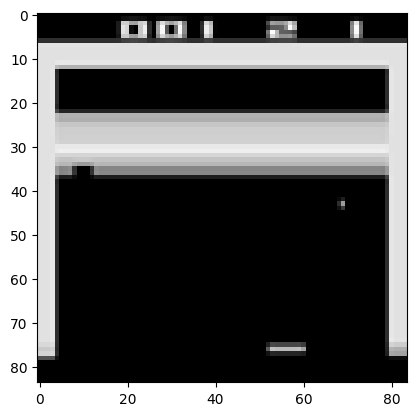

In [15]:
print(sample_images[-1].shape)
plt.imshow(sample_images[-1], cmap="gray")
plt.show()

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, Permute
from tensorflow.keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

In [4]:
env = gym.make("BreakoutDeterministic-v4")
nb_actions = env.action_space.n
nb_actions

4

In [5]:
IMG_SHAPE = (84, 84)
WINDOW_LENGTH = 4

In [6]:
class ImageProcessor(Processor):
    
    def process_observation(self, obs):
        img = Image.fromarray(obs)
        img = img.resize(IMG_SHAPE)
        img = img.convert("L")
        img = np.array(img)
        return img.astype("uint8")
    
    def process_state_batch(self, batch):
        processed_batch = batch.astype("float32")/255.0
        return processed_batch
    
    def process_reward(self, reward):
        return np.clip(reward, -1.0, 1.0)

In [7]:
input_shape = (WINDOW_LENGTH, IMG_SHAPE[0], IMG_SHAPE[1])
input_shape

(4, 84, 84)

To work with the Convolution2D (or Conv2D) we need have the shape (Batch, 84, 84, 4), but the input_shape has shape (4, 84, 84), we can use [**Permute**](https://keras.io/api/layers/reshaping_layers/permute/) to change the index positions.

In [8]:
model = Sequential()
# (Batch, 84, 84, 4)
model.add(Permute((2, 3, 1), input_shape=input_shape))

model.add(Conv2D(32, (8, 8), strides=(4, 4), kernel_initializer="he_normal"))
model.add(Activation("relu"))

model.add(Conv2D(64, (4, 4), strides=(4, 4), kernel_initializer="he_normal"))
model.add(Activation("relu"))

model.add(Conv2D(64, (3, 3), strides=(1, 1), kernel_initializer="he_normal"))
model.add(Activation("relu"))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))

model.add(Dense(nb_actions))
model.add(Activation("linear"))

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute (Permute)            (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 20, 32)        8224      
_________________________________________________________________
activation (Activation)      (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 64)          32832     
_________________________________________________________________
activation_1 (Activation)    (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________

In [10]:
memory = SequentialMemory(limit=1_000_000, window_length=WINDOW_LENGTH)
processor = ImageProcessor()

In [12]:
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(),
                              attr="eps",
                              value_max=1.0,
                              value_min=0.1,
                              value_test=0.05,
                              nb_steps=1_000_000)

In [13]:
dqn = DQNAgent(model=model,
               nb_actions=nb_actions,
               policy=policy,
               memory=memory,
               processor=processor,
               nb_steps_warmup=50_000,
               gamma=0.99,
               target_model_update=10_000,
               train_interval=4,
               delta_clip=1)

In [14]:
dqn.compile(Adam(learning_rate=0.00025), metrics=["mae"])

In [15]:
weights_filename = "dqn_bo.h5f"
checkpoint_filename = "dqn_checkpoint.h5f"
checkpoint_callback = ModelIntervalCheckpoint(checkpoint_filename, interval=100_000)

In [16]:
dqn.fit(env, nb_steps=1_000_000, callbacks=[checkpoint_callback],
        log_interval=500, visualize=False)

Training for 1000000 steps ...
Interval 1 (0 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: 0.0060
2 episodes - episode_reward: 0.500 [0.000, 1.000] - ale.lives: 3.130

Interval 2 (500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: 0.0100
3 episodes - episode_reward: 2.333 [2.000, 3.000] - ale.lives: 2.750

Interval 3 (1000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: 0.0100
2 episodes - episode_reward: 2.500 [2.000, 3.000] - ale.lives: 3.532

Interval 4 (1500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: 0.0040
3 episodes - episode_reward: 0.667 [0.000, 2.000] - ale.lives: 3.150

Interval 5 (2000 steps performed)
500/500 [==============================] - 4s 9ms/step - reward: 0.0060
3 episodes - episode_reward: 0.667 [0.000, 1.000] - ale.lives: 3.008

Interval 6 (2500 steps performed)
500/500 [==============================] - 5s 9ms/step - re

500/500 [==============================] - 4s 9ms/step - reward: 0.0060
3 episodes - episode_reward: 1.333 [1.000, 2.000] - ale.lives: 3.030

Interval 48 (23500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: 0.0060
3 episodes - episode_reward: 1.000 [0.000, 2.000] - ale.lives: 2.890

Interval 49 (24000 steps performed)
500/500 [==============================] - 5s 9ms/step - reward: 0.0080
2 episodes - episode_reward: 1.000 [1.000, 1.000] - ale.lives: 2.846

Interval 50 (24500 steps performed)
500/500 [==============================] - 4s 9ms/step - reward: 0.0060
3 episodes - episode_reward: 1.667 [1.000, 3.000] - ale.lives: 2.726

Interval 51 (25000 steps performed)
500/500 [==============================] - 4s 9ms/step - reward: 0.0080
2 episodes - episode_reward: 1.000 [0.000, 2.000] - ale.lives: 3.206

Interval 52 (25500 steps performed)
500/500 [==============================] - 5s 10ms/step - reward: 0.0080
3 episodes - episode_reward: 2.000 [2

500/500 [==============================] - 4s 9ms/step - reward: 0.0100
3 episodes - episode_reward: 1.333 [0.000, 3.000] - ale.lives: 2.840

Interval 94 (46500 steps performed)
500/500 [==============================] - 4s 9ms/step - reward: 0.0060
2 episodes - episode_reward: 2.000 [1.000, 3.000] - ale.lives: 2.664

Interval 95 (47000 steps performed)
500/500 [==============================] - 4s 9ms/step - reward: 0.0060
3 episodes - episode_reward: 1.000 [0.000, 2.000] - ale.lives: 2.992

Interval 96 (47500 steps performed)
500/500 [==============================] - 4s 9ms/step - reward: 0.0080
2 episodes - episode_reward: 2.000 [2.000, 2.000] - ale.lives: 3.216

Interval 97 (48000 steps performed)
500/500 [==============================] - 4s 9ms/step - reward: 0.0060
3 episodes - episode_reward: 1.000 [0.000, 2.000] - ale.lives: 2.956

Interval 98 (48500 steps performed)
500/500 [==============================] - 4s 9ms/step - reward: 0.0080
3 episodes - episode_reward: 1.333 [0.

500/500 [==============================] - 22s 43ms/step - reward: 0.0040
3 episodes - episode_reward: 0.333 [0.000, 1.000] - loss: 0.001 - mae: 0.085 - mean_q: 0.115 - mean_eps: 0.942 - ale.lives: 2.952

Interval 130 (64500 steps performed)
500/500 [==============================] - 22s 44ms/step - reward: 0.0020
4 episodes - episode_reward: 0.500 [0.000, 1.000] - loss: 0.001 - mae: 0.082 - mean_q: 0.111 - mean_eps: 0.942 - ale.lives: 3.172

Interval 131 (65000 steps performed)
500/500 [==============================] - 22s 43ms/step - reward: 0.0040
3 episodes - episode_reward: 0.667 [0.000, 1.000] - loss: 0.001 - mae: 0.086 - mean_q: 0.119 - mean_eps: 0.941 - ale.lives: 2.908

Interval 132 (65500 steps performed)
500/500 [==============================] - 22s 44ms/step - reward: 0.0040
3 episodes - episode_reward: 0.667 [0.000, 1.000] - loss: 0.002 - mae: 0.086 - mean_q: 0.116 - mean_eps: 0.941 - ale.lives: 2.782

Interval 133 (66000 steps performed)
500/500 [=======================

500/500 [==============================] - 23s 45ms/step - reward: 0.0020
3 episodes - episode_reward: 0.333 [0.000, 1.000] - loss: 0.001 - mae: 0.097 - mean_q: 0.129 - mean_eps: 0.927 - ale.lives: 2.974

Interval 164 (81500 steps performed)
500/500 [==============================] - 22s 44ms/step - reward: 0.0020
4 episodes - episode_reward: 0.250 [0.000, 1.000] - loss: 0.001 - mae: 0.101 - mean_q: 0.136 - mean_eps: 0.926 - ale.lives: 2.752

Interval 165 (82000 steps performed)
500/500 [==============================] - 22s 43ms/step - reward: 0.0040
3 episodes - episode_reward: 0.667 [0.000, 2.000] - loss: 0.001 - mae: 0.096 - mean_q: 0.129 - mean_eps: 0.926 - ale.lives: 3.120

Interval 166 (82500 steps performed)
500/500 [==============================] - 22s 44ms/step - reward: 0.0040
3 episodes - episode_reward: 0.667 [0.000, 1.000] - loss: 0.001 - mae: 0.095 - mean_q: 0.128 - mean_eps: 0.926 - ale.lives: 3.266

Interval 167 (83000 steps performed)
500/500 [=======================

500/500 [==============================] - 23s 47ms/step - reward: 0.0060
2 episodes - episode_reward: 1.000 [0.000, 2.000] - loss: 0.001 - mae: 0.096 - mean_q: 0.128 - mean_eps: 0.912 - ale.lives: 3.210

Interval 198 (98500 steps performed)
500/500 [==============================] - 23s 46ms/step - reward: 0.0100
3 episodes - episode_reward: 2.000 [2.000, 2.000] - loss: 0.000 - mae: 0.094 - mean_q: 0.126 - mean_eps: 0.911 - ale.lives: 3.026

Interval 199 (99000 steps performed)
500/500 [==============================] - 23s 46ms/step - reward: 0.0060
3 episodes - episode_reward: 0.667 [0.000, 2.000] - loss: 0.001 - mae: 0.096 - mean_q: 0.129 - mean_eps: 0.911 - ale.lives: 2.986

Interval 200 (99500 steps performed)
500/500 [==============================] - 24s 48ms/step - reward: 0.0080
3 episodes - episode_reward: 1.667 [0.000, 3.000] - loss: 0.001 - mae: 0.095 - mean_q: 0.128 - mean_eps: 0.910 - ale.lives: 2.816

Interval 201 (100000 steps performed)
500/500 [======================

500/500 [==============================] - 22s 45ms/step - reward: 0.0080
2 episodes - episode_reward: 1.500 [1.000, 2.000] - loss: 0.000 - mae: 0.107 - mean_q: 0.143 - mean_eps: 0.896 - ale.lives: 2.944

Interval 232 (115500 steps performed)
500/500 [==============================] - 23s 45ms/step - reward: 0.0020
4 episodes - episode_reward: 0.500 [0.000, 1.000] - loss: 0.000 - mae: 0.110 - mean_q: 0.147 - mean_eps: 0.896 - ale.lives: 2.942

Interval 233 (116000 steps performed)
500/500 [==============================] - 23s 45ms/step - reward: 0.0040
3 episodes - episode_reward: 0.667 [0.000, 1.000] - loss: 0.000 - mae: 0.107 - mean_q: 0.143 - mean_eps: 0.895 - ale.lives: 3.102

Interval 234 (116500 steps performed)
500/500 [==============================] - 22s 45ms/step - reward: 0.0140
2 episodes - episode_reward: 2.500 [2.000, 3.000] - loss: 0.000 - mae: 0.105 - mean_q: 0.140 - mean_eps: 0.895 - ale.lives: 3.090

Interval 235 (117000 steps performed)
500/500 [===================

500/500 [==============================] - 23s 45ms/step - reward: 0.0060
3 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.001 - mae: 0.114 - mean_q: 0.152 - mean_eps: 0.881 - ale.lives: 3.124

Interval 266 (132500 steps performed)
500/500 [==============================] - 22s 45ms/step - reward: 0.0120
2 episodes - episode_reward: 3.500 [2.000, 5.000] - loss: 0.001 - mae: 0.117 - mean_q: 0.156 - mean_eps: 0.881 - ale.lives: 2.726

Interval 267 (133000 steps performed)
500/500 [==============================] - 23s 46ms/step - reward: 0.0040
3 episodes - episode_reward: 1.333 [0.000, 3.000] - loss: 0.000 - mae: 0.115 - mean_q: 0.153 - mean_eps: 0.880 - ale.lives: 2.860

Interval 268 (133500 steps performed)
500/500 [==============================] - 23s 46ms/step - reward: 0.0060
3 episodes - episode_reward: 0.667 [0.000, 2.000] - loss: 0.000 - mae: 0.119 - mean_q: 0.159 - mean_eps: 0.880 - ale.lives: 3.020

Interval 269 (134000 steps performed)
500/500 [===================

500/500 [==============================] - 23s 47ms/step - reward: 0.0080
3 episodes - episode_reward: 1.667 [1.000, 3.000] - loss: 0.000 - mae: 0.119 - mean_q: 0.160 - mean_eps: 0.866 - ale.lives: 3.608

Interval 300 (149500 steps performed)
500/500 [==============================] - 23s 46ms/step - reward: 0.0080
2 episodes - episode_reward: 2.000 [2.000, 2.000] - loss: 0.000 - mae: 0.124 - mean_q: 0.165 - mean_eps: 0.865 - ale.lives: 2.884

Interval 301 (150000 steps performed)
500/500 [==============================] - 23s 46ms/step - reward: 0.0040
3 episodes - episode_reward: 0.667 [0.000, 1.000] - loss: 0.003 - mae: 0.136 - mean_q: 0.180 - mean_eps: 0.865 - ale.lives: 2.870

Interval 302 (150500 steps performed)
500/500 [==============================] - 22s 44ms/step - reward: 0.0100
2 episodes - episode_reward: 1.000 [0.000, 2.000] - loss: 0.001 - mae: 0.132 - mean_q: 0.176 - mean_eps: 0.864 - ale.lives: 3.096

Interval 303 (151000 steps performed)
500/500 [===================

500/500 [==============================] - 23s 45ms/step - reward: 0.0080
3 episodes - episode_reward: 2.000 [1.000, 3.000] - loss: 0.000 - mae: 0.139 - mean_q: 0.186 - mean_eps: 0.850 - ale.lives: 3.136

Interval 334 (166500 steps performed)
500/500 [==============================] - 22s 43ms/step - reward: 0.0100
2 episodes - episode_reward: 2.500 [2.000, 3.000] - loss: 0.000 - mae: 0.140 - mean_q: 0.187 - mean_eps: 0.850 - ale.lives: 3.350

Interval 335 (167000 steps performed)
500/500 [==============================] - 22s 45ms/step - reward: 0.0040
3 episodes - episode_reward: 0.667 [0.000, 2.000] - loss: 0.001 - mae: 0.141 - mean_q: 0.188 - mean_eps: 0.849 - ale.lives: 2.988

Interval 336 (167500 steps performed)
500/500 [==============================] - 22s 44ms/step - reward: 0.0120
2 episodes - episode_reward: 2.000 [2.000, 2.000] - loss: 0.000 - mae: 0.142 - mean_q: 0.190 - mean_eps: 0.849 - ale.lives: 2.880

Interval 337 (168000 steps performed)
500/500 [===================

500/500 [==============================] - 23s 47ms/step - reward: 0.0100
2 episodes - episode_reward: 3.000 [3.000, 3.000] - loss: 0.001 - mae: 0.165 - mean_q: 0.219 - mean_eps: 0.835 - ale.lives: 2.922

Interval 368 (183500 steps performed)
500/500 [==============================] - 23s 47ms/step - reward: 0.0040
3 episodes - episode_reward: 1.000 [1.000, 1.000] - loss: 0.001 - mae: 0.163 - mean_q: 0.216 - mean_eps: 0.835 - ale.lives: 3.136

Interval 369 (184000 steps performed)
500/500 [==============================] - 23s 46ms/step - reward: 0.0040
3 episodes - episode_reward: 0.333 [0.000, 1.000] - loss: 0.001 - mae: 0.162 - mean_q: 0.216 - mean_eps: 0.834 - ale.lives: 3.006

Interval 370 (184500 steps performed)
500/500 [==============================] - 22s 43ms/step - reward: 0.0060
3 episodes - episode_reward: 1.000 [0.000, 2.000] - loss: 0.001 - mae: 0.163 - mean_q: 0.217 - mean_eps: 0.834 - ale.lives: 2.824

Interval 371 (185000 steps performed)
500/500 [===================

3 episodes - episode_reward: 1.000 [0.000, 2.000] - loss: 0.000 - mae: 0.158 - mean_q: 0.211 - mean_eps: 0.820 - ale.lives: 2.968

Interval 401 (200000 steps performed)
500/500 [==============================] - 22s 45ms/step - reward: 0.0080
2 episodes - episode_reward: 2.000 [1.000, 3.000] - loss: 0.003 - mae: 0.177 - mean_q: 0.234 - mean_eps: 0.820 - ale.lives: 3.154

Interval 402 (200500 steps performed)
500/500 [==============================] - 23s 47ms/step - reward: 0.0080
3 episodes - episode_reward: 1.333 [0.000, 3.000] - loss: 0.001 - mae: 0.162 - mean_q: 0.216 - mean_eps: 0.819 - ale.lives: 3.112

Interval 403 (201000 steps performed)
500/500 [==============================] - 23s 46ms/step - reward: 0.0060
3 episodes - episode_reward: 1.000 [0.000, 2.000] - loss: 0.001 - mae: 0.167 - mean_q: 0.223 - mean_eps: 0.819 - ale.lives: 3.024

Interval 404 (201500 steps performed)
500/500 [==============================] - 22s 45ms/step - reward: 0.0020
3 episodes - episode_reward:

500/500 [==============================] - 23s 45ms/step - reward: 0.0100
3 episodes - episode_reward: 1.333 [1.000, 2.000] - loss: 0.001 - mae: 0.187 - mean_q: 0.250 - mean_eps: 0.805 - ale.lives: 3.364

Interval 435 (217000 steps performed)
500/500 [==============================] - 23s 46ms/step - reward: 0.0100
2 episodes - episode_reward: 2.500 [2.000, 3.000] - loss: 0.001 - mae: 0.188 - mean_q: 0.253 - mean_eps: 0.804 - ale.lives: 2.992

Interval 436 (217500 steps performed)
500/500 [==============================] - 23s 46ms/step - reward: 0.0060
3 episodes - episode_reward: 1.333 [0.000, 2.000] - loss: 0.001 - mae: 0.186 - mean_q: 0.249 - mean_eps: 0.804 - ale.lives: 2.892

Interval 437 (218000 steps performed)
500/500 [==============================] - 23s 46ms/step - reward: 0.0080
3 episodes - episode_reward: 1.667 [0.000, 3.000] - loss: 0.001 - mae: 0.188 - mean_q: 0.253 - mean_eps: 0.804 - ale.lives: 2.432

Interval 438 (218500 steps performed)
500/500 [===================

500/500 [==============================] - 23s 45ms/step - reward: 0.0100
3 episodes - episode_reward: 2.333 [0.000, 5.000] - loss: 0.002 - mae: 0.200 - mean_q: 0.275 - mean_eps: 0.790 - ale.lives: 2.840

Interval 469 (234000 steps performed)
500/500 [==============================] - 23s 46ms/step - reward: 0.0100
2 episodes - episode_reward: 2.000 [2.000, 2.000] - loss: 0.001 - mae: 0.212 - mean_q: 0.290 - mean_eps: 0.789 - ale.lives: 3.206

Interval 470 (234500 steps performed)
500/500 [==============================] - 24s 47ms/step - reward: 0.0080
2 episodes - episode_reward: 2.500 [0.000, 5.000] - loss: 0.001 - mae: 0.211 - mean_q: 0.291 - mean_eps: 0.789 - ale.lives: 2.756

Interval 471 (235000 steps performed)
500/500 [==============================] - 23s 46ms/step - reward: 0.0060
3 episodes - episode_reward: 0.667 [0.000, 1.000] - loss: 0.001 - mae: 0.208 - mean_q: 0.283 - mean_eps: 0.788 - ale.lives: 2.994

Interval 472 (235500 steps performed)
500/500 [===================

500/500 [==============================] - 23s 46ms/step - reward: 0.0080
3 episodes - episode_reward: 1.333 [1.000, 2.000] - loss: 0.003 - mae: 0.243 - mean_q: 0.338 - mean_eps: 0.774 - ale.lives: 3.032

Interval 503 (251000 steps performed)
500/500 [==============================] - 23s 45ms/step - reward: 0.0080
2 episodes - episode_reward: 1.500 [0.000, 3.000] - loss: 0.002 - mae: 0.249 - mean_q: 0.347 - mean_eps: 0.774 - ale.lives: 2.676

Interval 504 (251500 steps performed)
500/500 [==============================] - 23s 45ms/step - reward: 0.0120
2 episodes - episode_reward: 0.500 [0.000, 1.000] - loss: 0.002 - mae: 0.238 - mean_q: 0.332 - mean_eps: 0.773 - ale.lives: 2.970

Interval 505 (252000 steps performed)
500/500 [==============================] - 23s 45ms/step - reward: 0.0060
3 episodes - episode_reward: 3.000 [0.000, 6.000] - loss: 0.002 - mae: 0.244 - mean_q: 0.342 - mean_eps: 0.773 - ale.lives: 2.946

Interval 506 (252500 steps performed)
500/500 [===================

500/500 [==============================] - 23s 47ms/step - reward: 0.0060
3 episodes - episode_reward: 1.000 [0.000, 2.000] - loss: 0.002 - mae: 0.265 - mean_q: 0.378 - mean_eps: 0.759 - ale.lives: 2.876

Interval 537 (268000 steps performed)
500/500 [==============================] - 24s 48ms/step - reward: 0.0100
2 episodes - episode_reward: 2.500 [0.000, 5.000] - loss: 0.002 - mae: 0.266 - mean_q: 0.380 - mean_eps: 0.759 - ale.lives: 2.998

Interval 538 (268500 steps performed)
500/500 [==============================] - 24s 47ms/step - reward: 0.0080
2 episodes - episode_reward: 1.000 [1.000, 1.000] - loss: 0.001 - mae: 0.254 - mean_q: 0.362 - mean_eps: 0.758 - ale.lives: 2.472

Interval 539 (269000 steps performed)
500/500 [==============================] - 23s 47ms/step - reward: 0.0160
2 episodes - episode_reward: 2.500 [2.000, 3.000] - loss: 0.001 - mae: 0.268 - mean_q: 0.381 - mean_eps: 0.758 - ale.lives: 3.588

Interval 540 (269500 steps performed)
500/500 [===================

500/500 [==============================] - 23s 46ms/step - reward: 0.0100
2 episodes - episode_reward: 1.500 [1.000, 2.000] - loss: 0.002 - mae: 0.316 - mean_q: 0.447 - mean_eps: 0.744 - ale.lives: 3.262

Interval 571 (285000 steps performed)
500/500 [==============================] - 23s 46ms/step - reward: 0.0080
2 episodes - episode_reward: 2.500 [2.000, 3.000] - loss: 0.002 - mae: 0.319 - mean_q: 0.451 - mean_eps: 0.743 - ale.lives: 3.216

Interval 572 (285500 steps performed)
500/500 [==============================] - 23s 46ms/step - reward: 0.0120
3 episodes - episode_reward: 2.333 [1.000, 5.000] - loss: 0.002 - mae: 0.325 - mean_q: 0.460 - mean_eps: 0.743 - ale.lives: 2.564

Interval 573 (286000 steps performed)
500/500 [==============================] - 23s 46ms/step - reward: 0.0100
2 episodes - episode_reward: 1.500 [0.000, 3.000] - loss: 0.002 - mae: 0.315 - mean_q: 0.445 - mean_eps: 0.742 - ale.lives: 3.022

Interval 574 (286500 steps performed)
500/500 [===================

500/500 [==============================] - 23s 46ms/step - reward: 0.0120
2 episodes - episode_reward: 4.500 [3.000, 6.000] - loss: 0.003 - mae: 0.384 - mean_q: 0.543 - mean_eps: 0.728 - ale.lives: 2.650

Interval 605 (302000 steps performed)
500/500 [==============================] - 23s 46ms/step - reward: 0.0060
2 episodes - episode_reward: 1.500 [1.000, 2.000] - loss: 0.002 - mae: 0.360 - mean_q: 0.507 - mean_eps: 0.728 - ale.lives: 2.820

Interval 606 (302500 steps performed)
500/500 [==============================] - 23s 46ms/step - reward: 0.0160
2 episodes - episode_reward: 4.000 [1.000, 7.000] - loss: 0.002 - mae: 0.378 - mean_q: 0.531 - mean_eps: 0.728 - ale.lives: 3.090

Interval 607 (303000 steps performed)
500/500 [==============================] - 23s 46ms/step - reward: 0.0120
2 episodes - episode_reward: 2.000 [1.000, 3.000] - loss: 0.002 - mae: 0.382 - mean_q: 0.539 - mean_eps: 0.727 - ale.lives: 3.156

Interval 608 (303500 steps performed)
500/500 [===================

500/500 [==============================] - 23s 47ms/step - reward: 0.0060
3 episodes - episode_reward: 3.000 [0.000, 7.000] - loss: 0.003 - mae: 0.401 - mean_q: 0.569 - mean_eps: 0.713 - ale.lives: 3.324

Interval 639 (319000 steps performed)
500/500 [==============================] - 23s 46ms/step - reward: 0.0100
2 episodes - episode_reward: 1.500 [1.000, 2.000] - loss: 0.003 - mae: 0.411 - mean_q: 0.580 - mean_eps: 0.713 - ale.lives: 3.526

Interval 640 (319500 steps performed)
500/500 [==============================] - 23s 46ms/step - reward: 0.0140
1 episodes - episode_reward: 4.000 [4.000, 4.000] - loss: 0.002 - mae: 0.426 - mean_q: 0.601 - mean_eps: 0.712 - ale.lives: 3.054

Interval 641 (320000 steps performed)
500/500 [==============================] - 23s 47ms/step - reward: 0.0100
3 episodes - episode_reward: 3.333 [2.000, 5.000] - loss: 0.012 - mae: 0.452 - mean_q: 0.630 - mean_eps: 0.712 - ale.lives: 3.278

Interval 642 (320500 steps performed)
500/500 [===================

500/500 [==============================] - 23s 46ms/step - reward: 0.0060
3 episodes - episode_reward: 2.333 [1.000, 4.000] - loss: 0.002 - mae: 0.463 - mean_q: 0.653 - mean_eps: 0.698 - ale.lives: 3.146

Interval 673 (336000 steps performed)
500/500 [==============================] - 24s 47ms/step - reward: 0.0080
3 episodes - episode_reward: 1.333 [0.000, 2.000] - loss: 0.002 - mae: 0.464 - mean_q: 0.654 - mean_eps: 0.697 - ale.lives: 2.874

Interval 674 (336500 steps performed)
500/500 [==============================] - 23s 46ms/step - reward: 0.0100
2 episodes - episode_reward: 1.000 [1.000, 1.000] - loss: 0.003 - mae: 0.466 - mean_q: 0.663 - mean_eps: 0.697 - ale.lives: 2.966

Interval 675 (337000 steps performed)
500/500 [==============================] - 23s 47ms/step - reward: 0.0060
3 episodes - episode_reward: 2.000 [0.000, 5.000] - loss: 0.002 - mae: 0.473 - mean_q: 0.671 - mean_eps: 0.696 - ale.lives: 2.696

Interval 676 (337500 steps performed)
500/500 [===================

500/500 [==============================] - 23s 46ms/step - reward: 0.0060
3 episodes - episode_reward: 1.000 [0.000, 2.000] - loss: 0.003 - mae: 0.548 - mean_q: 0.776 - mean_eps: 0.683 - ale.lives: 2.432

Interval 707 (353000 steps performed)
500/500 [==============================] - 23s 46ms/step - reward: 0.0100
2 episodes - episode_reward: 1.500 [0.000, 3.000] - loss: 0.002 - mae: 0.557 - mean_q: 0.786 - mean_eps: 0.682 - ale.lives: 3.354

Interval 708 (353500 steps performed)
500/500 [==============================] - 23s 47ms/step - reward: 0.0100
2 episodes - episode_reward: 2.500 [2.000, 3.000] - loss: 0.002 - mae: 0.558 - mean_q: 0.789 - mean_eps: 0.682 - ale.lives: 3.214

Interval 709 (354000 steps performed)
500/500 [==============================] - 23s 45ms/step - reward: 0.0100
2 episodes - episode_reward: 3.000 [2.000, 4.000] - loss: 0.002 - mae: 0.542 - mean_q: 0.764 - mean_eps: 0.681 - ale.lives: 2.626

Interval 710 (354500 steps performed)
500/500 [===================

500/500 [==============================] - 24s 47ms/step - reward: 0.0140
2 episodes - episode_reward: 1.500 [1.000, 2.000] - loss: 0.008 - mae: 0.610 - mean_q: 0.935 - mean_eps: 0.667 - ale.lives: 3.450

Interval 741 (370000 steps performed)
500/500 [==============================] - 24s 47ms/step - reward: 0.0140
2 episodes - episode_reward: 5.500 [5.000, 6.000] - loss: 0.024 - mae: 0.702 - mean_q: 0.998 - mean_eps: 0.667 - ale.lives: 2.464

Interval 742 (370500 steps performed)
500/500 [==============================] - 24s 48ms/step - reward: 0.0080
2 episodes - episode_reward: 2.500 [2.000, 3.000] - loss: 0.019 - mae: 0.696 - mean_q: 0.988 - mean_eps: 0.666 - ale.lives: 2.938

Interval 743 (371000 steps performed)
500/500 [==============================] - 24s 48ms/step - reward: 0.0180
1 episodes - episode_reward: 6.000 [6.000, 6.000] - loss: 0.017 - mae: 0.696 - mean_q: 0.982 - mean_eps: 0.666 - ale.lives: 2.576

Interval 744 (371500 steps performed)
500/500 [===================

500/500 [==============================] - 23s 47ms/step - reward: 0.0140
2 episodes - episode_reward: 4.000 [1.000, 7.000] - loss: 0.012 - mae: 0.747 - mean_q: 1.044 - mean_eps: 0.652 - ale.lives: 3.266

Interval 775 (387000 steps performed)
500/500 [==============================] - 24s 47ms/step - reward: 0.0100
2 episodes - episode_reward: 2.000 [0.000, 4.000] - loss: 0.013 - mae: 0.753 - mean_q: 1.050 - mean_eps: 0.651 - ale.lives: 3.586

Interval 776 (387500 steps performed)
500/500 [==============================] - 24s 48ms/step - reward: 0.0100
2 episodes - episode_reward: 3.500 [3.000, 4.000] - loss: 0.013 - mae: 0.749 - mean_q: 1.050 - mean_eps: 0.651 - ale.lives: 2.900

Interval 777 (388000 steps performed)
500/500 [==============================] - 24s 47ms/step - reward: 0.0100
2 episodes - episode_reward: 1.500 [0.000, 3.000] - loss: 0.011 - mae: 0.738 - mean_q: 1.033 - mean_eps: 0.651 - ale.lives: 3.404

Interval 778 (388500 steps performed)
500/500 [===================

500/500 [==============================] - 24s 48ms/step - reward: 0.0060
3 episodes - episode_reward: 2.000 [0.000, 6.000] - loss: 0.007 - mae: 0.819 - mean_q: 1.132 - mean_eps: 0.637 - ale.lives: 2.522

Interval 809 (404000 steps performed)
500/500 [==============================] - 24s 47ms/step - reward: 0.0000e+00
3 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.007 - mae: 0.834 - mean_q: 1.156 - mean_eps: 0.636 - ale.lives: 2.834

Interval 810 (404500 steps performed)
500/500 [==============================] - 24s 47ms/step - reward: 0.0100
3 episodes - episode_reward: 1.667 [0.000, 5.000] - loss: 0.006 - mae: 0.818 - mean_q: 1.130 - mean_eps: 0.636 - ale.lives: 2.570

Interval 811 (405000 steps performed)
500/500 [==============================] - 24s 48ms/step - reward: 0.0080
2 episodes - episode_reward: 1.500 [0.000, 3.000] - loss: 0.006 - mae: 0.830 - mean_q: 1.146 - mean_eps: 0.635 - ale.lives: 2.852

Interval 812 (405500 steps performed)
500/500 [===============

500/500 [==============================] - 26s 52ms/step - reward: 0.0120
2 episodes - episode_reward: 5.500 [4.000, 7.000] - loss: 0.006 - mae: 0.883 - mean_q: 1.219 - mean_eps: 0.621 - ale.lives: 3.486

Interval 843 (421000 steps performed)
500/500 [==============================] - 28s 55ms/step - reward: 0.0120
2 episodes - episode_reward: 4.000 [4.000, 4.000] - loss: 0.006 - mae: 0.877 - mean_q: 1.212 - mean_eps: 0.621 - ale.lives: 2.876

Interval 844 (421500 steps performed)
500/500 [==============================] - 27s 53ms/step - reward: 0.0180
1 episodes - episode_reward: 2.000 [2.000, 2.000] - loss: 0.005 - mae: 0.877 - mean_q: 1.210 - mean_eps: 0.620 - ale.lives: 2.876

Interval 845 (422000 steps performed)
500/500 [==============================] - 25s 51ms/step - reward: 0.0160
2 episodes - episode_reward: 6.000 [4.000, 8.000] - loss: 0.005 - mae: 0.878 - mean_q: 1.212 - mean_eps: 0.620 - ale.lives: 3.604

Interval 846 (422500 steps performed)
500/500 [===================

500/500 [==============================] - 25s 50ms/step - reward: 0.0140
1 episodes - episode_reward: 5.000 [5.000, 5.000] - loss: 0.005 - mae: 0.910 - mean_q: 1.249 - mean_eps: 0.606 - ale.lives: 2.964

Interval 877 (438000 steps performed)
500/500 [==============================] - 25s 50ms/step - reward: 0.0120
1 episodes - episode_reward: 3.000 [3.000, 3.000] - loss: 0.004 - mae: 0.915 - mean_q: 1.254 - mean_eps: 0.606 - ale.lives: 2.794

Interval 878 (438500 steps performed)
500/500 [==============================] - 25s 50ms/step - reward: 0.0120
2 episodes - episode_reward: 3.500 [2.000, 5.000] - loss: 0.005 - mae: 0.917 - mean_q: 1.258 - mean_eps: 0.605 - ale.lives: 3.022

Interval 879 (439000 steps performed)
500/500 [==============================] - 25s 50ms/step - reward: 0.0160
1 episodes - episode_reward: 5.000 [5.000, 5.000] - loss: 0.004 - mae: 0.911 - mean_q: 1.249 - mean_eps: 0.605 - ale.lives: 2.720

Interval 880 (439500 steps performed)
500/500 [===================

500/500 [==============================] - 27s 55ms/step - reward: 0.0160
1 episodes - episode_reward: 6.000 [6.000, 6.000] - loss: 0.003 - mae: 0.962 - mean_q: 1.310 - mean_eps: 0.591 - ale.lives: 2.534

Interval 911 (455000 steps performed)
500/500 [==============================] - 25s 50ms/step - reward: 0.0100
2 episodes - episode_reward: 2.500 [2.000, 3.000] - loss: 0.003 - mae: 0.965 - mean_q: 1.309 - mean_eps: 0.590 - ale.lives: 2.808

Interval 912 (455500 steps performed)
500/500 [==============================] - 28s 56ms/step - reward: 0.0180
2 episodes - episode_reward: 5.000 [4.000, 6.000] - loss: 0.003 - mae: 0.959 - mean_q: 1.302 - mean_eps: 0.590 - ale.lives: 2.332

Interval 913 (456000 steps performed)
500/500 [==============================] - 25s 50ms/step - reward: 0.0220
1 episodes - episode_reward: 11.000 [11.000, 11.000] - loss: 0.003 - mae: 0.963 - mean_q: 1.309 - mean_eps: 0.589 - ale.lives: 2.788

Interval 914 (456500 steps performed)
500/500 [================

500/500 [==============================] - 27s 53ms/step - reward: 0.0100
3 episodes - episode_reward: 2.333 [0.000, 5.000] - loss: 0.003 - mae: 0.992 - mean_q: 1.342 - mean_eps: 0.575 - ale.lives: 2.976

Interval 945 (472000 steps performed)
500/500 [==============================] - 27s 53ms/step - reward: 0.0080
2 episodes - episode_reward: 1.500 [1.000, 2.000] - loss: 0.003 - mae: 0.989 - mean_q: 1.339 - mean_eps: 0.575 - ale.lives: 3.194

Interval 946 (472500 steps performed)
500/500 [==============================] - 25s 51ms/step - reward: 0.0100
2 episodes - episode_reward: 2.000 [1.000, 3.000] - loss: 0.003 - mae: 0.993 - mean_q: 1.343 - mean_eps: 0.575 - ale.lives: 2.734

Interval 947 (473000 steps performed)
500/500 [==============================] - 25s 51ms/step - reward: 0.0100
3 episodes - episode_reward: 2.333 [2.000, 3.000] - loss: 0.004 - mae: 0.992 - mean_q: 1.343 - mean_eps: 0.574 - ale.lives: 2.788

Interval 948 (473500 steps performed)
500/500 [===================

500/500 [==============================] - 25s 50ms/step - reward: 0.0120
2 episodes - episode_reward: 2.000 [1.000, 3.000] - loss: 0.003 - mae: 1.003 - mean_q: 1.356 - mean_eps: 0.560 - ale.lives: 3.000

Interval 979 (489000 steps performed)
500/500 [==============================] - 25s 50ms/step - reward: 0.0100
2 episodes - episode_reward: 3.500 [3.000, 4.000] - loss: 0.002 - mae: 1.005 - mean_q: 1.358 - mean_eps: 0.560 - ale.lives: 2.910

Interval 980 (489500 steps performed)
500/500 [==============================] - 25s 50ms/step - reward: 0.0140
2 episodes - episode_reward: 3.000 [2.000, 4.000] - loss: 0.002 - mae: 1.006 - mean_q: 1.360 - mean_eps: 0.559 - ale.lives: 2.452

Interval 981 (490000 steps performed)
500/500 [==============================] - 25s 50ms/step - reward: 0.0120
2 episodes - episode_reward: 3.500 [2.000, 5.000] - loss: 0.003 - mae: 1.014 - mean_q: 1.367 - mean_eps: 0.559 - ale.lives: 2.876

Interval 982 (490500 steps performed)
500/500 [===================

500/500 [==============================] - 25s 51ms/step - reward: 0.0100
2 episodes - episode_reward: 4.000 [2.000, 6.000] - loss: 0.003 - mae: 1.020 - mean_q: 1.374 - mean_eps: 0.545 - ale.lives: 2.840

Interval 1013 (506000 steps performed)
500/500 [==============================] - 26s 51ms/step - reward: 0.0140
2 episodes - episode_reward: 4.500 [3.000, 6.000] - loss: 0.002 - mae: 1.023 - mean_q: 1.381 - mean_eps: 0.544 - ale.lives: 3.540

Interval 1014 (506500 steps performed)
500/500 [==============================] - 25s 51ms/step - reward: 0.0160
1 episodes - episode_reward: 7.000 [7.000, 7.000] - loss: 0.003 - mae: 1.021 - mean_q: 1.376 - mean_eps: 0.544 - ale.lives: 2.630

Interval 1015 (507000 steps performed)
500/500 [==============================] - 26s 52ms/step - reward: 0.0060
3 episodes - episode_reward: 1.000 [0.000, 2.000] - loss: 0.003 - mae: 1.016 - mean_q: 1.369 - mean_eps: 0.543 - ale.lives: 2.918

Interval 1016 (507500 steps performed)
500/500 [===============

500/500 [==============================] - 26s 52ms/step - reward: 0.0200
1 episodes - episode_reward: 7.000 [7.000, 7.000] - loss: 0.002 - mae: 1.032 - mean_q: 1.389 - mean_eps: 0.530 - ale.lives: 2.404

Interval 1047 (523000 steps performed)
500/500 [==============================] - 27s 53ms/step - reward: 0.0100
2 episodes - episode_reward: 3.000 [2.000, 4.000] - loss: 0.002 - mae: 1.040 - mean_q: 1.399 - mean_eps: 0.529 - ale.lives: 3.036

Interval 1048 (523500 steps performed)
500/500 [==============================] - 28s 56ms/step - reward: 0.0180
1 episodes - episode_reward: 4.000 [4.000, 4.000] - loss: 0.002 - mae: 1.038 - mean_q: 1.397 - mean_eps: 0.529 - ale.lives: 2.818

Interval 1049 (524000 steps performed)
500/500 [==============================] - 27s 55ms/step - reward: 0.0120
2 episodes - episode_reward: 6.500 [6.000, 7.000] - loss: 0.002 - mae: 1.035 - mean_q: 1.394 - mean_eps: 0.528 - ale.lives: 2.834

Interval 1050 (524500 steps performed)
500/500 [===============

500/500 [==============================] - 27s 54ms/step - reward: 0.0160
1 episodes - episode_reward: 8.000 [8.000, 8.000] - loss: 0.002 - mae: 1.043 - mean_q: 1.404 - mean_eps: 0.514 - ale.lives: 2.308

Interval 1081 (540000 steps performed)
500/500 [==============================] - 26s 51ms/step - reward: 0.0040
3 episodes - episode_reward: 0.667 [0.000, 1.000] - loss: 0.003 - mae: 1.046 - mean_q: 1.406 - mean_eps: 0.514 - ale.lives: 3.258

Interval 1082 (540500 steps performed)
500/500 [==============================] - 26s 53ms/step - reward: 0.0020
3 episodes - episode_reward: 0.333 [0.000, 1.000] - loss: 0.002 - mae: 1.046 - mean_q: 1.407 - mean_eps: 0.513 - ale.lives: 3.096

Interval 1083 (541000 steps performed)
500/500 [==============================] - 26s 52ms/step - reward: 0.0100
1 episodes - episode_reward: 2.000 [2.000, 2.000] - loss: 0.002 - mae: 1.052 - mean_q: 1.415 - mean_eps: 0.513 - ale.lives: 2.546

Interval 1084 (541500 steps performed)
500/500 [===============

500/500 [==============================] - 24s 49ms/step - reward: 0.0060
3 episodes - episode_reward: 0.333 [0.000, 1.000] - loss: 0.002 - mae: 1.056 - mean_q: 1.421 - mean_eps: 0.499 - ale.lives: 3.486

Interval 1115 (557000 steps performed)
500/500 [==============================] - 23s 47ms/step - reward: 0.0160
1 episodes - episode_reward: 8.000 [8.000, 8.000] - loss: 0.002 - mae: 1.052 - mean_q: 1.414 - mean_eps: 0.498 - ale.lives: 2.546

Interval 1116 (557500 steps performed)
500/500 [==============================] - 24s 48ms/step - reward: 0.0120
2 episodes - episode_reward: 2.500 [1.000, 4.000] - loss: 0.002 - mae: 1.053 - mean_q: 1.417 - mean_eps: 0.498 - ale.lives: 2.862

Interval 1117 (558000 steps performed)
500/500 [==============================] - 24s 47ms/step - reward: 0.0140
2 episodes - episode_reward: 5.000 [5.000, 5.000] - loss: 0.002 - mae: 1.055 - mean_q: 1.419 - mean_eps: 0.498 - ale.lives: 2.244

Interval 1118 (558500 steps performed)
500/500 [===============

500/500 [==============================] - 23s 46ms/step - reward: 0.0100
2 episodes - episode_reward: 2.000 [0.000, 4.000] - loss: 0.002 - mae: 1.064 - mean_q: 1.429 - mean_eps: 0.484 - ale.lives: 2.156

Interval 1149 (574000 steps performed)
500/500 [==============================] - 24s 47ms/step - reward: 0.0100
2 episodes - episode_reward: 3.000 [2.000, 4.000] - loss: 0.002 - mae: 1.056 - mean_q: 1.421 - mean_eps: 0.483 - ale.lives: 2.120

Interval 1150 (574500 steps performed)
500/500 [==============================] - 24s 47ms/step - reward: 0.0060
3 episodes - episode_reward: 1.000 [0.000, 2.000] - loss: 0.002 - mae: 1.060 - mean_q: 1.426 - mean_eps: 0.483 - ale.lives: 2.686

Interval 1151 (575000 steps performed)
500/500 [==============================] - 24s 49ms/step - reward: 0.0120
2 episodes - episode_reward: 2.500 [1.000, 4.000] - loss: 0.002 - mae: 1.054 - mean_q: 1.418 - mean_eps: 0.482 - ale.lives: 2.968

Interval 1152 (575500 steps performed)
500/500 [===============

500/500 [==============================] - 24s 48ms/step - reward: 0.0100
2 episodes - episode_reward: 2.000 [2.000, 2.000] - loss: 0.003 - mae: 1.068 - mean_q: 1.435 - mean_eps: 0.468 - ale.lives: 2.274

Interval 1183 (591000 steps performed)
500/500 [==============================] - 24s 48ms/step - reward: 0.0180
2 episodes - episode_reward: 5.500 [4.000, 7.000] - loss: 0.002 - mae: 1.070 - mean_q: 1.438 - mean_eps: 0.468 - ale.lives: 3.386

Interval 1184 (591500 steps performed)
500/500 [==============================] - 23s 47ms/step - reward: 0.0160
1 episodes - episode_reward: 8.000 [8.000, 8.000] - loss: 0.002 - mae: 1.077 - mean_q: 1.446 - mean_eps: 0.467 - ale.lives: 2.954

Interval 1185 (592000 steps performed)
500/500 [==============================] - 24s 47ms/step - reward: 0.0080
2 episodes - episode_reward: 2.000 [0.000, 4.000] - loss: 0.002 - mae: 1.073 - mean_q: 1.441 - mean_eps: 0.467 - ale.lives: 2.422

Interval 1186 (592500 steps performed)
500/500 [===============

500/500 [==============================] - 24s 48ms/step - reward: 0.0040
3 episodes - episode_reward: 0.667 [0.000, 2.000] - loss: 0.002 - mae: 1.075 - mean_q: 1.443 - mean_eps: 0.453 - ale.lives: 2.610

Interval 1217 (608000 steps performed)
500/500 [==============================] - 24s 48ms/step - reward: 0.0120
2 episodes - episode_reward: 3.000 [2.000, 4.000] - loss: 0.002 - mae: 1.081 - mean_q: 1.451 - mean_eps: 0.453 - ale.lives: 2.192

Interval 1218 (608500 steps performed)
500/500 [==============================] - 24s 49ms/step - reward: 0.0060
2 episodes - episode_reward: 1.500 [0.000, 3.000] - loss: 0.002 - mae: 1.086 - mean_q: 1.456 - mean_eps: 0.452 - ale.lives: 2.840

Interval 1219 (609000 steps performed)
500/500 [==============================] - 24s 48ms/step - reward: 0.0080
2 episodes - episode_reward: 2.000 [1.000, 3.000] - loss: 0.002 - mae: 1.071 - mean_q: 1.438 - mean_eps: 0.452 - ale.lives: 2.344

Interval 1220 (609500 steps performed)
500/500 [===============

500/500 [==============================] - 24s 49ms/step - reward: 0.0160
1 episodes - episode_reward: 3.000 [3.000, 3.000] - loss: 0.002 - mae: 1.071 - mean_q: 1.438 - mean_eps: 0.438 - ale.lives: 3.202

Interval 1251 (625000 steps performed)
500/500 [==============================] - 24s 49ms/step - reward: 0.0100
2 episodes - episode_reward: 5.000 [0.000, 10.000] - loss: 0.002 - mae: 1.076 - mean_q: 1.445 - mean_eps: 0.437 - ale.lives: 2.602

Interval 1252 (625500 steps performed)
500/500 [==============================] - 25s 51ms/step - reward: 0.0140
2 episodes - episode_reward: 3.500 [2.000, 5.000] - loss: 0.002 - mae: 1.074 - mean_q: 1.442 - mean_eps: 0.437 - ale.lives: 1.880

Interval 1253 (626000 steps performed)
500/500 [==============================] - 25s 49ms/step - reward: 0.0040
3 episodes - episode_reward: 0.667 [0.000, 1.000] - loss: 0.002 - mae: 1.077 - mean_q: 1.445 - mean_eps: 0.436 - ale.lives: 2.742

Interval 1254 (626500 steps performed)
500/500 [==============

500/500 [==============================] - 25s 49ms/step - reward: 0.0140
2 episodes - episode_reward: 3.000 [1.000, 5.000] - loss: 0.003 - mae: 1.067 - mean_q: 1.432 - mean_eps: 0.422 - ale.lives: 2.668

Interval 1285 (642000 steps performed)
500/500 [==============================] - 24s 49ms/step - reward: 0.0120
1 episodes - episode_reward: 4.000 [4.000, 4.000] - loss: 0.002 - mae: 1.064 - mean_q: 1.430 - mean_eps: 0.422 - ale.lives: 1.980

Interval 1286 (642500 steps performed)
500/500 [==============================] - 24s 49ms/step - reward: 0.0160
2 episodes - episode_reward: 5.500 [4.000, 7.000] - loss: 0.002 - mae: 1.066 - mean_q: 1.432 - mean_eps: 0.422 - ale.lives: 2.434

Interval 1287 (643000 steps performed)
500/500 [==============================] - 25s 50ms/step - reward: 0.0100
2 episodes - episode_reward: 2.500 [2.000, 3.000] - loss: 0.002 - mae: 1.072 - mean_q: 1.441 - mean_eps: 0.421 - ale.lives: 2.380

Interval 1288 (643500 steps performed)
500/500 [===============

500/500 [==============================] - 25s 51ms/step - reward: 0.0160
1 episodes - episode_reward: 6.000 [6.000, 6.000] - loss: 0.001 - mae: 1.073 - mean_q: 1.442 - mean_eps: 0.407 - ale.lives: 2.308

Interval 1319 (659000 steps performed)
500/500 [==============================] - 25s 51ms/step - reward: 0.0100
3 episodes - episode_reward: 2.667 [2.000, 3.000] - loss: 0.002 - mae: 1.071 - mean_q: 1.439 - mean_eps: 0.407 - ale.lives: 3.122

Interval 1320 (659500 steps performed)
500/500 [==============================] - 25s 51ms/step - reward: 0.0100
2 episodes - episode_reward: 2.500 [2.000, 3.000] - loss: 0.001 - mae: 1.066 - mean_q: 1.434 - mean_eps: 0.406 - ale.lives: 2.720

Interval 1321 (660000 steps performed)
500/500 [==============================] - 26s 51ms/step - reward: 0.0160
1 episodes - episode_reward: 5.000 [5.000, 5.000] - loss: 0.002 - mae: 1.072 - mean_q: 1.442 - mean_eps: 0.406 - ale.lives: 2.758

Interval 1322 (660500 steps performed)
500/500 [===============

500/500 [==============================] - 25s 49ms/step - reward: 0.0180
1 episodes - episode_reward: 5.000 [5.000, 5.000] - loss: 0.002 - mae: 1.079 - mean_q: 1.453 - mean_eps: 0.392 - ale.lives: 3.226

Interval 1353 (676000 steps performed)
500/500 [==============================] - 25s 50ms/step - reward: 0.0180
1 episodes - episode_reward: 7.000 [7.000, 7.000] - loss: 0.002 - mae: 1.082 - mean_q: 1.457 - mean_eps: 0.391 - ale.lives: 3.038

Interval 1354 (676500 steps performed)
500/500 [==============================] - 25s 49ms/step - reward: 0.0080
2 episodes - episode_reward: 5.500 [3.000, 8.000] - loss: 0.002 - mae: 1.076 - mean_q: 1.450 - mean_eps: 0.391 - ale.lives: 2.818

Interval 1355 (677000 steps performed)
500/500 [==============================] - 24s 49ms/step - reward: 0.0180
1 episodes - episode_reward: 4.000 [4.000, 4.000] - loss: 0.002 - mae: 1.084 - mean_q: 1.459 - mean_eps: 0.390 - ale.lives: 3.306

Interval 1356 (677500 steps performed)
500/500 [===============

500/500 [==============================] - 25s 49ms/step - reward: 0.0160
1 episodes - episode_reward: 4.000 [4.000, 4.000] - loss: 0.002 - mae: 1.106 - mean_q: 1.491 - mean_eps: 0.377 - ale.lives: 3.886

Interval 1387 (693000 steps performed)
500/500 [==============================] - 25s 50ms/step - reward: 0.0140
1 episodes - episode_reward: 9.000 [9.000, 9.000] - loss: 0.002 - mae: 1.099 - mean_q: 1.482 - mean_eps: 0.376 - ale.lives: 2.710

Interval 1388 (693500 steps performed)
500/500 [==============================] - 26s 51ms/step - reward: 0.0200
1 episodes - episode_reward: 8.000 [8.000, 8.000] - loss: 0.002 - mae: 1.100 - mean_q: 1.482 - mean_eps: 0.376 - ale.lives: 2.994

Interval 1389 (694000 steps performed)
500/500 [==============================] - 25s 50ms/step - reward: 0.0200
1 episodes - episode_reward: 10.000 [10.000, 10.000] - loss: 0.002 - mae: 1.086 - mean_q: 1.464 - mean_eps: 0.375 - ale.lives: 3.128

Interval 1390 (694500 steps performed)
500/500 [============

500/500 [==============================] - 25s 50ms/step - reward: 0.0200
1 episodes - episode_reward: 4.000 [4.000, 4.000] - loss: 0.002 - mae: 1.111 - mean_q: 1.498 - mean_eps: 0.360 - ale.lives: 3.566

Interval 1423 (711000 steps performed)
500/500 [==============================] - 25s 50ms/step - reward: 0.0200
1 episodes - episode_reward: 12.000 [12.000, 12.000] - loss: 0.002 - mae: 1.114 - mean_q: 1.503 - mean_eps: 0.360 - ale.lives: 2.930

Interval 1424 (711500 steps performed)
500/500 [==============================] - 25s 50ms/step - reward: 0.0180
2 episodes - episode_reward: 5.500 [4.000, 7.000] - loss: 0.002 - mae: 1.107 - mean_q: 1.493 - mean_eps: 0.359 - ale.lives: 3.282

Interval 1425 (712000 steps performed)
500/500 [==============================] - 25s 50ms/step - reward: 0.0200
1 episodes - episode_reward: 11.000 [11.000, 11.000] - loss: 0.002 - mae: 1.109 - mean_q: 1.497 - mean_eps: 0.359 - ale.lives: 3.078

Interval 1426 (712500 steps performed)
500/500 [=========

500/500 [==============================] - 25s 51ms/step - reward: 0.0200
1 episodes - episode_reward: 10.000 [10.000, 10.000] - loss: 0.002 - mae: 1.133 - mean_q: 1.527 - mean_eps: 0.345 - ale.lives: 2.792

Interval 1458 (728500 steps performed)
500/500 [==============================] - 25s 50ms/step - reward: 0.0200
2 episodes - episode_reward: 6.500 [6.000, 7.000] - loss: 0.002 - mae: 1.137 - mean_q: 1.536 - mean_eps: 0.344 - ale.lives: 3.144

Interval 1459 (729000 steps performed)
500/500 [==============================] - 25s 51ms/step - reward: 0.0200
1 episodes - episode_reward: 7.000 [7.000, 7.000] - loss: 0.002 - mae: 1.131 - mean_q: 1.526 - mean_eps: 0.344 - ale.lives: 3.670

Interval 1460 (729500 steps performed)
500/500 [==============================] - 25s 51ms/step - reward: 0.0220
1 episodes - episode_reward: 8.000 [8.000, 8.000] - loss: 0.002 - mae: 1.137 - mean_q: 1.536 - mean_eps: 0.343 - ale.lives: 3.650

Interval 1461 (730000 steps performed)
500/500 [============

500/500 [==============================] - 26s 51ms/step - reward: 0.0220
1 episodes - episode_reward: 16.000 [16.000, 16.000] - loss: 0.002 - mae: 1.148 - mean_q: 1.553 - mean_eps: 0.329 - ale.lives: 2.758

Interval 1493 (746000 steps performed)
500/500 [==============================] - 26s 52ms/step - reward: 0.0180
1 episodes - episode_reward: 9.000 [9.000, 9.000] - loss: 0.002 - mae: 1.153 - mean_q: 1.562 - mean_eps: 0.328 - ale.lives: 3.154

Interval 1494 (746500 steps performed)
500/500 [==============================] - 26s 53ms/step - reward: 0.0240
1 episodes - episode_reward: 9.000 [9.000, 9.000] - loss: 0.002 - mae: 1.150 - mean_q: 1.556 - mean_eps: 0.328 - ale.lives: 2.960

Interval 1495 (747000 steps performed)
500/500 [==============================] - 25s 50ms/step - reward: 0.0200
1 episodes - episode_reward: 11.000 [11.000, 11.000] - loss: 0.002 - mae: 1.151 - mean_q: 1.558 - mean_eps: 0.327 - ale.lives: 3.266

Interval 1496 (747500 steps performed)
500/500 [=========

500/500 [==============================] - 25s 50ms/step - reward: 0.0180
1 episodes - episode_reward: 11.000 [11.000, 11.000] - loss: 0.003 - mae: 1.173 - mean_q: 1.586 - mean_eps: 0.313 - ale.lives: 2.930

Interval 1529 (764000 steps performed)
500/500 [==============================] - 26s 52ms/step - reward: 0.0180
2 episodes - episode_reward: 6.000 [4.000, 8.000] - loss: 0.002 - mae: 1.181 - mean_q: 1.599 - mean_eps: 0.312 - ale.lives: 3.094

Interval 1530 (764500 steps performed)
500/500 [==============================] - 26s 53ms/step - reward: 0.0240
1 episodes - episode_reward: 14.000 [14.000, 14.000] - loss: 0.002 - mae: 1.179 - mean_q: 1.592 - mean_eps: 0.312 - ale.lives: 3.212

Interval 1531 (765000 steps performed)
500/500 [==============================] - 26s 52ms/step - reward: 0.0240
1 episodes - episode_reward: 11.000 [11.000, 11.000] - loss: 0.002 - mae: 1.175 - mean_q: 1.586 - mean_eps: 0.311 - ale.lives: 3.240

Interval 1532 (765500 steps performed)
500/500 [======

500/500 [==============================] - 26s 52ms/step - reward: 0.0220
1 episodes - episode_reward: 15.000 [15.000, 15.000] - loss: 0.002 - mae: 1.189 - mean_q: 1.610 - mean_eps: 0.296 - ale.lives: 2.470

Interval 1565 (782000 steps performed)
500/500 [==============================] - 25s 51ms/step - reward: 0.0240
1 episodes - episode_reward: 9.000 [9.000, 9.000] - loss: 0.002 - mae: 1.197 - mean_q: 1.621 - mean_eps: 0.296 - ale.lives: 3.220

Interval 1566 (782500 steps performed)
500/500 [==============================] - 25s 49ms/step - reward: 0.0240
1 episodes - episode_reward: 11.000 [11.000, 11.000] - loss: 0.002 - mae: 1.191 - mean_q: 1.614 - mean_eps: 0.296 - ale.lives: 3.324

Interval 1567 (783000 steps performed)
500/500 [==============================] - 25s 50ms/step - reward: 0.0180
2 episodes - episode_reward: 10.000 [9.000, 11.000] - loss: 0.002 - mae: 1.194 - mean_q: 1.618 - mean_eps: 0.295 - ale.lives: 2.782

Interval 1568 (783500 steps performed)
500/500 [=======

500/500 [==============================] - 25s 51ms/step - reward: 0.0220
1 episodes - episode_reward: 11.000 [11.000, 11.000] - loss: 0.004 - mae: 1.235 - mean_q: 1.677 - mean_eps: 0.280 - ale.lives: 3.374

Interval 1602 (800500 steps performed)
500/500 [==============================] - 26s 51ms/step - reward: 0.0240
1 episodes - episode_reward: 16.000 [16.000, 16.000] - loss: 0.003 - mae: 1.242 - mean_q: 1.686 - mean_eps: 0.279 - ale.lives: 2.506

Interval 1603 (801000 steps performed)
500/500 [==============================] - 25s 51ms/step - reward: 0.0220
1 episodes - episode_reward: 10.000 [10.000, 10.000] - loss: 0.003 - mae: 1.229 - mean_q: 1.672 - mean_eps: 0.279 - ale.lives: 3.146

Interval 1604 (801500 steps performed)
500/500 [==============================] - 26s 53ms/step - reward: 0.0240
1 episodes - episode_reward: 11.000 [11.000, 11.000] - loss: 0.003 - mae: 1.236 - mean_q: 1.678 - mean_eps: 0.278 - ale.lives: 2.782

Interval 1605 (802000 steps performed)
500/500 [===

500/500 [==============================] - 27s 54ms/step - reward: 0.0260
Interval 1639 (819000 steps performed)
500/500 [==============================] - 27s 54ms/step - reward: 0.0240
1 episodes - episode_reward: 15.000 [15.000, 15.000] - loss: 0.003 - mae: 1.260 - mean_q: 1.707 - mean_eps: 0.263 - ale.lives: 3.558

Interval 1640 (819500 steps performed)
500/500 [==============================] - 27s 53ms/step - reward: 0.0200
1 episodes - episode_reward: 15.000 [15.000, 15.000] - loss: 0.003 - mae: 1.250 - mean_q: 1.693 - mean_eps: 0.262 - ale.lives: 3.052

Interval 1641 (820000 steps performed)
500/500 [==============================] - 27s 54ms/step - reward: 0.0240
1 episodes - episode_reward: 15.000 [15.000, 15.000] - loss: 0.003 - mae: 1.273 - mean_q: 1.721 - mean_eps: 0.262 - ale.lives: 3.072

Interval 1642 (820500 steps performed)
500/500 [==============================] - 27s 54ms/step - reward: 0.0220
Interval 1643 (821000 steps performed)
500/500 [========================

500/500 [==============================] - 25s 51ms/step - reward: 0.0220
Interval 1678 (838500 steps performed)
500/500 [==============================] - 25s 50ms/step - reward: 0.0240
1 episodes - episode_reward: 14.000 [14.000, 14.000] - loss: 0.002 - mae: 1.290 - mean_q: 1.748 - mean_eps: 0.245 - ale.lives: 4.004

Interval 1679 (839000 steps performed)
500/500 [==============================] - 25s 49ms/step - reward: 0.0200
1 episodes - episode_reward: 15.000 [15.000, 15.000] - loss: 0.002 - mae: 1.298 - mean_q: 1.756 - mean_eps: 0.245 - ale.lives: 3.212

Interval 1680 (839500 steps performed)
500/500 [==============================] - 25s 50ms/step - reward: 0.0220
1 episodes - episode_reward: 11.000 [11.000, 11.000] - loss: 0.002 - mae: 1.285 - mean_q: 1.740 - mean_eps: 0.244 - ale.lives: 3.220

Interval 1681 (840000 steps performed)
500/500 [==============================] - 25s 51ms/step - reward: 0.0260
1 episodes - episode_reward: 19.000 [19.000, 19.000] - loss: 0.003 - mae

500/500 [==============================] - 25s 50ms/step - reward: 0.0280
1 episodes - episode_reward: 13.000 [13.000, 13.000] - loss: 0.002 - mae: 1.316 - mean_q: 1.781 - mean_eps: 0.228 - ale.lives: 3.772

Interval 1716 (857500 steps performed)
500/500 [==============================] - 25s 51ms/step - reward: 0.0260
Interval 1717 (858000 steps performed)
500/500 [==============================] - 25s 50ms/step - reward: 0.0240
1 episodes - episode_reward: 22.000 [22.000, 22.000] - loss: 0.002 - mae: 1.312 - mean_q: 1.778 - mean_eps: 0.228 - ale.lives: 3.698

Interval 1718 (858500 steps performed)
500/500 [==============================] - 25s 49ms/step - reward: 0.0220
1 episodes - episode_reward: 17.000 [17.000, 17.000] - loss: 0.002 - mae: 1.297 - mean_q: 1.760 - mean_eps: 0.227 - ale.lives: 3.122

Interval 1719 (859000 steps performed)
500/500 [==============================] - 25s 50ms/step - reward: 0.0260
1 episodes - episode_reward: 13.000 [13.000, 13.000] - loss: 0.003 - mae

500/500 [==============================] - 26s 51ms/step - reward: 0.0260
Interval 1754 (876500 steps performed)
500/500 [==============================] - 26s 52ms/step - reward: 0.0240
1 episodes - episode_reward: 18.000 [18.000, 18.000] - loss: 0.002 - mae: 1.333 - mean_q: 1.809 - mean_eps: 0.211 - ale.lives: 3.220

Interval 1755 (877000 steps performed)
500/500 [==============================] - 25s 50ms/step - reward: 0.0220
1 episodes - episode_reward: 15.000 [15.000, 15.000] - loss: 0.002 - mae: 1.332 - mean_q: 1.805 - mean_eps: 0.210 - ale.lives: 2.830

Interval 1756 (877500 steps performed)
500/500 [==============================] - 26s 52ms/step - reward: 0.0180
1 episodes - episode_reward: 9.000 [9.000, 9.000] - loss: 0.002 - mae: 1.332 - mean_q: 1.807 - mean_eps: 0.210 - ale.lives: 3.698

Interval 1757 (878000 steps performed)
500/500 [==============================] - 25s 50ms/step - reward: 0.0200
1 episodes - episode_reward: 9.000 [9.000, 9.000] - loss: 0.003 - mae: 1.33

500/500 [==============================] - 25s 51ms/step - reward: 0.0200
1 episodes - episode_reward: 19.000 [19.000, 19.000] - loss: 0.003 - mae: 1.373 - mean_q: 1.853 - mean_eps: 0.194 - ale.lives: 2.966

Interval 1792 (895500 steps performed)
500/500 [==============================] - 26s 51ms/step - reward: 0.0260
Interval 1793 (896000 steps performed)
500/500 [==============================] - 25s 51ms/step - reward: 0.0220
1 episodes - episode_reward: 15.000 [15.000, 15.000] - loss: 0.002 - mae: 1.371 - mean_q: 1.853 - mean_eps: 0.193 - ale.lives: 3.332

Interval 1794 (896500 steps performed)
500/500 [==============================] - 26s 53ms/step - reward: 0.0260
1 episodes - episode_reward: 16.000 [16.000, 16.000] - loss: 0.003 - mae: 1.366 - mean_q: 1.849 - mean_eps: 0.193 - ale.lives: 3.224

Interval 1795 (897000 steps performed)
500/500 [==============================] - 26s 52ms/step - reward: 0.0220
1 episodes - episode_reward: 16.000 [16.000, 16.000] - loss: 0.003 - mae

500/500 [==============================] - 26s 52ms/step - reward: 0.0240
1 episodes - episode_reward: 21.000 [21.000, 21.000] - loss: 0.003 - mae: 1.390 - mean_q: 1.875 - mean_eps: 0.177 - ale.lives: 3.428

Interval 1831 (915000 steps performed)
500/500 [==============================] - 26s 52ms/step - reward: 0.0220
1 episodes - episode_reward: 17.000 [17.000, 17.000] - loss: 0.002 - mae: 1.385 - mean_q: 1.868 - mean_eps: 0.176 - ale.lives: 3.020

Interval 1832 (915500 steps performed)
500/500 [==============================] - 26s 52ms/step - reward: 0.0220
1 episodes - episode_reward: 15.000 [15.000, 15.000] - loss: 0.003 - mae: 1.401 - mean_q: 1.888 - mean_eps: 0.176 - ale.lives: 3.374

Interval 1833 (916000 steps performed)
500/500 [==============================] - 27s 53ms/step - reward: 0.0260
1 episodes - episode_reward: 13.000 [13.000, 13.000] - loss: 0.003 - mae: 1.390 - mean_q: 1.874 - mean_eps: 0.175 - ale.lives: 2.848

Interval 1834 (916500 steps performed)
500/500 [===

500/500 [==============================] - 26s 51ms/step - reward: 0.0240
Interval 1871 (935000 steps performed)
500/500 [==============================] - 26s 52ms/step - reward: 0.0220
2 episodes - episode_reward: 18.500 [11.000, 26.000] - loss: 0.002 - mae: 1.402 - mean_q: 1.890 - mean_eps: 0.158 - ale.lives: 3.458

Interval 1872 (935500 steps performed)
500/500 [==============================] - 26s 52ms/step - reward: 0.0240
Interval 1873 (936000 steps performed)
500/500 [==============================] - 26s 52ms/step - reward: 0.0240
1 episodes - episode_reward: 21.000 [21.000, 21.000] - loss: 0.002 - mae: 1.406 - mean_q: 1.897 - mean_eps: 0.157 - ale.lives: 2.666

Interval 1874 (936500 steps performed)
500/500 [==============================] - 26s 52ms/step - reward: 0.0260
Interval 1875 (937000 steps performed)
500/500 [==============================] - 26s 52ms/step - reward: 0.0260
1 episodes - episode_reward: 18.000 [18.000, 18.000] - loss: 0.002 - mae: 1.404 - mean_q: 1.8

500/500 [==============================] - 26s 52ms/step - reward: 0.0280
Interval 1912 (955500 steps performed)
500/500 [==============================] - 26s 52ms/step - reward: 0.0260
1 episodes - episode_reward: 23.000 [23.000, 23.000] - loss: 0.003 - mae: 1.414 - mean_q: 1.904 - mean_eps: 0.140 - ale.lives: 3.368

Interval 1913 (956000 steps performed)
500/500 [==============================] - 26s 53ms/step - reward: 0.0240
1 episodes - episode_reward: 16.000 [16.000, 16.000] - loss: 0.002 - mae: 1.409 - mean_q: 1.902 - mean_eps: 0.139 - ale.lives: 2.864

Interval 1914 (956500 steps performed)
500/500 [==============================] - 26s 52ms/step - reward: 0.0240
Interval 1915 (957000 steps performed)
500/500 [==============================] - 27s 53ms/step - reward: 0.0220
1 episodes - episode_reward: 20.000 [20.000, 20.000] - loss: 0.002 - mae: 1.418 - mean_q: 1.912 - mean_eps: 0.138 - ale.lives: 3.046

Interval 1916 (957500 steps performed)
500/500 [========================

500/500 [==============================] - 26s 52ms/step - reward: 0.0240
Interval 1953 (976000 steps performed)
500/500 [==============================] - 26s 52ms/step - reward: 0.0260
1 episodes - episode_reward: 20.000 [20.000, 20.000] - loss: 0.002 - mae: 1.436 - mean_q: 1.939 - mean_eps: 0.121 - ale.lives: 3.698

Interval 1954 (976500 steps performed)
500/500 [==============================] - 27s 53ms/step - reward: 0.0240
1 episodes - episode_reward: 12.000 [12.000, 12.000] - loss: 0.003 - mae: 1.436 - mean_q: 1.938 - mean_eps: 0.121 - ale.lives: 3.546

Interval 1955 (977000 steps performed)
500/500 [==============================] - 26s 52ms/step - reward: 0.0260
1 episodes - episode_reward: 16.000 [16.000, 16.000] - loss: 0.002 - mae: 1.437 - mean_q: 1.939 - mean_eps: 0.120 - ale.lives: 3.080

Interval 1956 (977500 steps performed)
500/500 [==============================] - 26s 53ms/step - reward: 0.0220
Interval 1957 (978000 steps performed)
500/500 [========================

500/500 [==============================] - 26s 52ms/step - reward: 0.0280
Interval 1993 (996000 steps performed)
500/500 [==============================] - 26s 53ms/step - reward: 0.0240
1 episodes - episode_reward: 26.000 [26.000, 26.000] - loss: 0.002 - mae: 1.447 - mean_q: 1.950 - mean_eps: 0.103 - ale.lives: 3.410

Interval 1994 (996500 steps performed)
500/500 [==============================] - 26s 52ms/step - reward: 0.0220
1 episodes - episode_reward: 14.000 [14.000, 14.000] - loss: 0.003 - mae: 1.451 - mean_q: 1.954 - mean_eps: 0.103 - ale.lives: 3.332

Interval 1995 (997000 steps performed)
500/500 [==============================] - 26s 53ms/step - reward: 0.0200
1 episodes - episode_reward: 15.000 [15.000, 15.000] - loss: 0.003 - mae: 1.447 - mean_q: 1.949 - mean_eps: 0.102 - ale.lives: 2.440

Interval 1996 (997500 steps performed)
500/500 [==============================] - 26s 52ms/step - reward: 0.0220
1 episodes - episode_reward: 11.000 [11.000, 11.000] - loss: 0.002 - mae

In [ ]:
dqn.test(env, nb_episodes=1, visualize=True)

In [12]:
# In case you want to train from an expecific checkpoint
model.load_weights("dqn_checkpoint.h5f")
# Start the value_max in 0.2 because you don't 
# need to make further exploration as in the begging of the training
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(0.1),
                              attr="eps",
                              value_max=0.2,
                              value_min=0.1,
                              value_test=0.05,
                              nb_steps=1_000)
dqn = DQNAgent(model=model,
               nb_actions=nb_actions,
               policy=policy,
               memory=memory,
               processor=processor,
               nb_steps_warmup=50_000,
               gamma=0.99,
               target_model_update=10_000,
               train_interval=4,
               delta_clip=1)
dqn.compile(Adam(learning_rate=0.00025), metrics=["mae"])
dqn.fit(env, nb_steps=1000, log_interval=500, visualize=False)
dqn.test(env, nb_episodes=1, visualize=True)

Training for 1000 steps ...
Interval 1 (0 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: 0.0200
Interval 2 (500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: 0.0200
done, took 8.292 seconds
